Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [20]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
from keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
# !pip install tensorflow==2.13.1
tf.__version__


'2.13.1'

In [ ]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Upgrad/CNN/CNN_assignment (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Upgrad/CNN')

In [11]:
import os

def extract_with_unzip(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    os.system(f"unzip -q {zip_path} -d {extract_to}")
    print(f"Extraction complete to {extract_to}")


zip_path = "/content/drive/MyDrive/Upgrad/CNN/CNN_assignment (1).zip"  # Adjust path
extract_to = "/content/drive/MyDrive/Upgrad/CNN"
extract_with_unzip(zip_path, extract_to)

Extraction complete to /content/drive/MyDrive/Upgrad/CNN


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

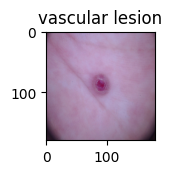

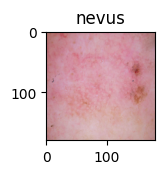

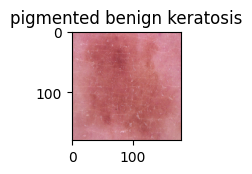

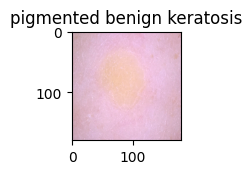

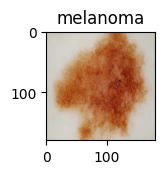

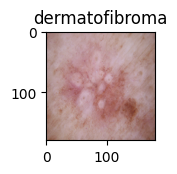

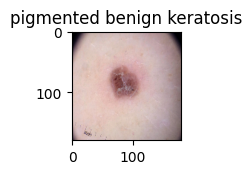

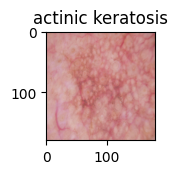

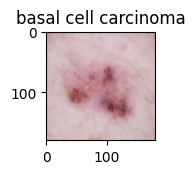

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
for images, labels in train_ds.take(1):
  for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

**Model 1**

In [45]:
# ### Your code goes here
def create_cnn_model(input_shape=(img_height, img_width, 3), num_classes=9):
    """
    Creates a CNN model for image classification with 9 classes.

    Args:
    - input_shape: Tuple representing the shape of input images (height, width, channels).
    - num_classes: Number of classes to classify.

    Returns:
    - A CNN model.
    """
    model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]

        # Convolutional  1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional  2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional  3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    return model



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [46]:
## Todo, choose an appropirate optimiser and loss function
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 45, 45, 128)      

### Train the model

In [48]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 167ms/step - loss: 2.1846 - accuracy: 0.1802 - val_loss: 2.0084 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 9s 169ms/step - loss: 1.9589 - accuracy: 0.2846 - val_loss: 1.7597 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 10s 171ms/step - loss: 1.8054 - accuracy: 0.3689 - val_loss: 1.6330 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 9s 162ms/step - loss: 1.7224 - accuracy: 0.3756 - val_loss: 1.6044 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 10s 171ms/step - loss: 1.6089 - accuracy: 0.4369 - val_loss: 1.6697 - val_accuracy: 0.3870
Epoch 6/20
56/56 [==============================] - 10s 171ms/step - loss: 1.5862 - accuracy: 0.4520 - val_loss: 1.5611 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 9s 165ms/step - loss: 1.5429 - accuracy: 0.4559 - val_loss: 1.5635 - val_accuracy: 0.4855
Ep

### Visualizing training results

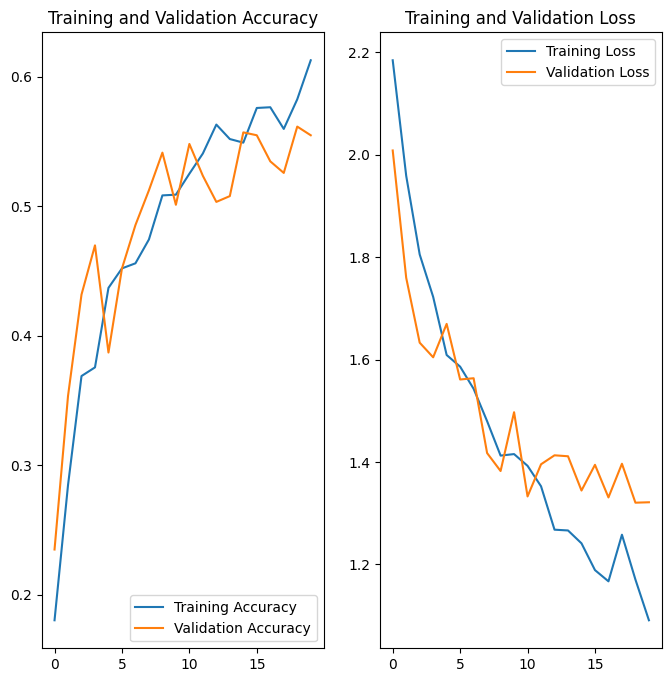

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### **Write your findings here**

- This is very initial model built with no batch normalization , no learning rate optimization or any other technique.
- However, the model is good, doesnt have much difference in training and validation.
- During training, the model starts learning steadily and its accuracy start from 18% to 61%, with decrease in training loss.
- For validation, the model accuracy increases 23% approx. and goes uptil 55% approx, with loss decreasing.
- However, validation loss stops improving and shows fluctations after 12th epoc.
- The model is mildly overfitting and needs further improvement.

### **Data Augmentation**

In [120]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = tf.keras.Sequential([
                                      layers.RandomFlip("horizontal_and_vertical"),       # Flip images horizontally
                                      layers.RandomRotation(0.4),           # Rotate images
                                      layers.RandomZoom(0.2),               # Zoom in/out
                                      layers.RandomTranslation(0.2, 0.2),
                                      layers.RandomContrast(0.1)


])

**Visualize Data**

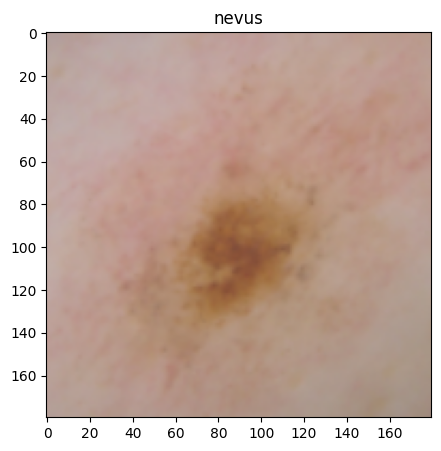

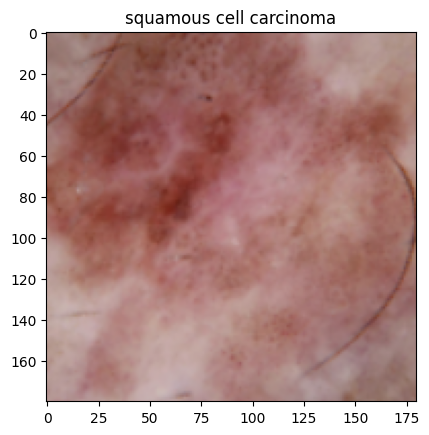

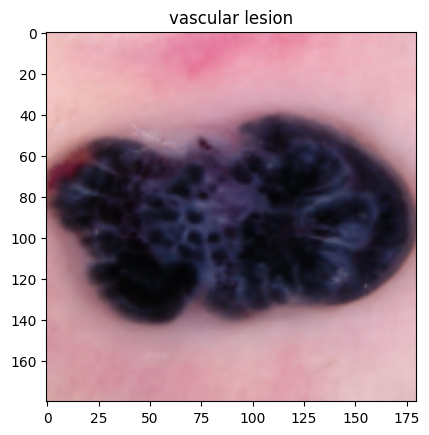

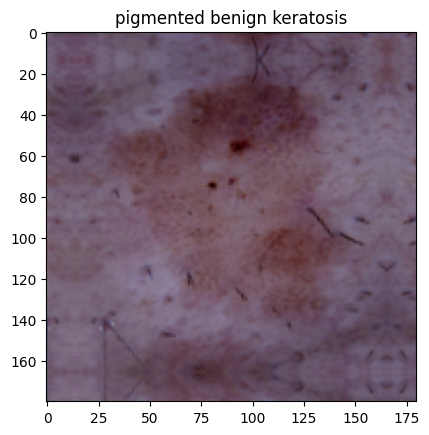

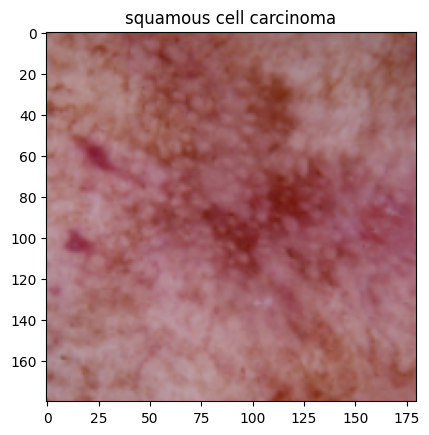

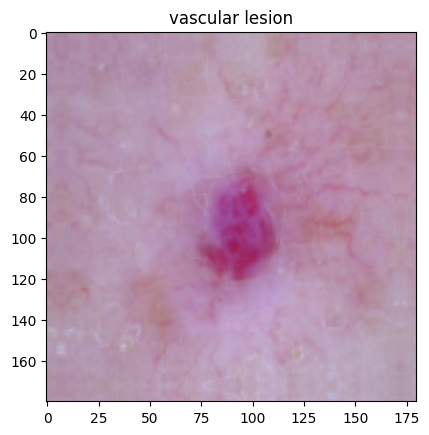

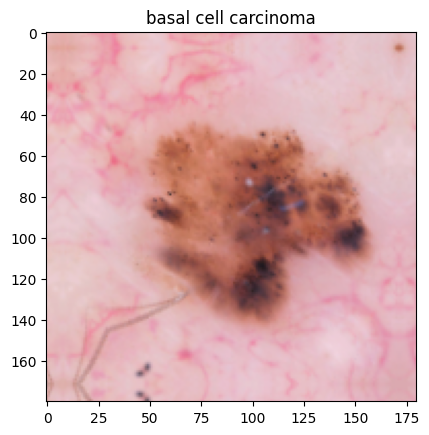

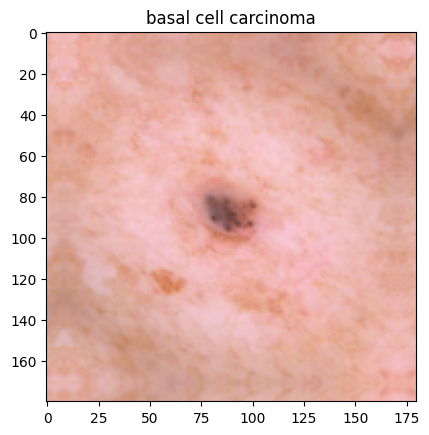

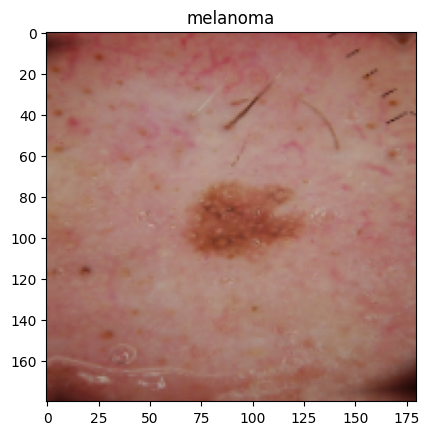

In [116]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.imshow(data_augmentation(images)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.show()

### Todo:
### Create the model, compile and train the model


**Model 2**

In [133]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

def create_cnn_model_with_dropouts(input_shape=(img_height, img_width, 3), num_classes=9):
    """
    Creates a CNN model for image classification with 9 classes.

    Args:
    - input_shape: Tuple representing the shape of input images (height, width, channels).
    - num_classes: Number of classes to classify.

    Returns:
    - A CNN model.
    """
    model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1.0 / 255),

        # Convolutional  1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional  2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Convolutional  3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Flatten and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    return model


### Compiling the model

In [134]:
## Your code goes here

model = create_cnn_model_with_dropouts()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_33 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

### Training the model

In [135]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 14s 229ms/step - loss: 2.2641 - accuracy: 0.1864 - val_loss: 2.0783 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - 13s 225ms/step - loss: 2.0195 - accuracy: 0.2478 - val_loss: 1.9830 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 13s 226ms/step - loss: 1.8757 - accuracy: 0.3209 - val_loss: 1.8165 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 13s 225ms/step - loss: 1.8071 - accuracy: 0.3309 - val_loss: 1.7983 - val_accuracy: 0.3647
Epoch 5/20
56/56 [==============================] - 13s 223ms/step - loss: 1.7518 - accuracy: 0.3571 - val_loss: 1.5814 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 13s 225ms/step - loss: 1.7099 - accuracy: 0.3806 - val_loss: 1.5909 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 13s 225ms/step - loss: 1.6092 - accuracy: 0.4129 - val_loss: 1.6212 - val_accuracy: 0.4653
Epoch 8/20

### Visualizing the results

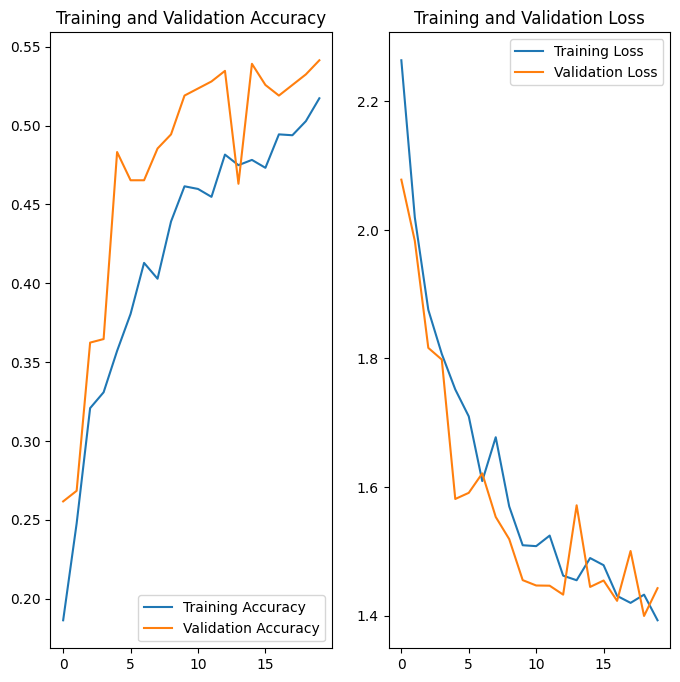

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo**: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- **Inference regarding the model:**

1.   The model is still simple with lesser paramaters.
2.   Model has been steadily learning during training and validation ranging from approx.(18% - 51% ) and (26% - 54%) respectively.
3. Both training loss and validation loss has been decreasing and training accuracy and validation accuracy has been increasing which suggests that model has been progressing over time and can perform better on training data.
4. Above point also suggests that model is not overfitting and data augmentation has certainly helped without changing any other parameter.

- **Comparison with pervious model**
1. Earlier model was slighlitly overfitting and needed further improvement.
2. After doing data augmementation and adding dropot layers have tackled the case of overfitting. This model is more steady compared to previous one.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
def file_count(directory):
  count = []
  for path in pathlib.Path(directory).iterdir():
          if path.is_dir():
              count.append(len([name for name in os.listdir(path)
                                if os.path.isfile(os.path.join(path, name))]))

      #name of the classes
  sub_folder = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

      #return dataframe with image count and class.
  return pd.DataFrame(list(zip(sub_folder,count)),columns =['Class', 'Image_Count'])

df = file_count(data_dir_train)
df.sort_values(by='Image_Count', ascending=False)

,Class,Image_Count
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


<Axes: xlabel='Class'>

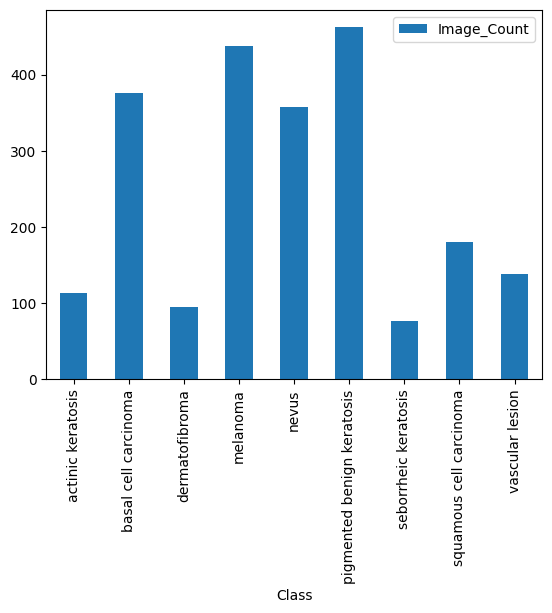

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

df.plot(kind = 'bar', x='Class', y='Image_Count')

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? - **seborrheic keratosis** has the lowest count
#### - Which classes dominate the data in terms proportionate number of samples? - **pigmented benign keratosis** dominates over other samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor==0.2.8
!pip install --upgrade Pillow

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
import os
from PIL import Image
for i in class_names:
    image_dir = os.path.join(path_to_training_dataset, i)  # Construct full image directory path
    if os.path.isdir(image_dir) and any(file.endswith(('.jpg', '.jpeg', '.png')) for file in os.listdir(image_dir)):
      p = Augmentor.Pipeline(image_dir)
      p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
      p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    else:
        print(f"Warning: Directory '{image_dir}' is empty or does not contain valid images.")

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F6040E6B0>: 100%|██████████| 500/500 [00:25<00:00, 19.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F606C38E0>: 100%|██████████| 500/500 [00:21<00:00, 23.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F607CFAC0>: 100%|██████████| 500/500 [00:23<00:00, 21.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x790F604090F0>: 100%|██████████| 500/500 [01:30<00:00,  5.50 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x790F6A1F0DF0>: 100%|██████████| 500/500 [01:24<00:00,  5.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F7801C0D0>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x790F6034CDF0>: 100%|██████████| 500/500 [00:44<00:00, 11.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F6034F790>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790F607C37F0>: 100%|██████████| 500/500 [00:23<00:00, 21.06 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [36]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [37]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,actinic keratosis
1,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,actinic keratosis
2,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,actinic keratosis
3,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,actinic keratosis
4,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,vascular lesion
2235,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,vascular lesion
2236,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,vascular lesion
2237,/content/drive/MyDrive/Upgrad/CNN/Skin cancer ...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_54d153e6-fe29-47f7-9602-73bdc5647cc8.jpg',
 '/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_86d56e72-e8f8-40ee-9037-52e681aea8e7.jpg',
 '/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_59af53a7-9a39-42cf-969c-ce4ce6e00c17.jpg',
 '/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_4d0f5db6-2ceb-4ab5-8733-6e39685ec9a5.jpg',
 '/content/drive/MyDrive/Upgrad/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df._append(df2)

In [42]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

**Model 3**

In [229]:
## your code goes here
from keras import regularizers
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Enhancing the model by adding BatchNormalization, an additional layer and different learning rates
def create_augmented_cnn_model(input_shape=(img_height, img_width, 3), num_classes=9):
    """
    Creates a CNN model for image classification with 9 classes.

    Args:
    - input_shape: Tuple representing the shape of input images (height, width, channels).
    - num_classes: Number of classes to classify.

    Returns:
    - A CNN model.
    """
    model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]

        # Convolution 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Convolutional  2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Convolutional 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Convolutional 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [230]:
## your code goes here
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tensorflow.keras.backend as backend


early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3) # early Stopping

model = create_augmented_cnn_model()
optimizer = Adam(0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [231]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stop]
)

Epoch 1/30
169/169 [==============================] - 17s 87ms/step - loss: 3.3936 - accuracy: 0.3386 - val_loss: 4.4301 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 15s 86ms/step - loss: 2.8971 - accuracy: 0.4598 - val_loss: 4.1837 - val_accuracy: 0.1284
Epoch 3/30
169/169 [==============================] - 15s 86ms/step - loss: 2.7306 - accuracy: 0.4955 - val_loss: 3.5996 - val_accuracy: 0.1722
Epoch 4/30
169/169 [==============================] - 15s 86ms/step - loss: 2.5902 - accuracy: 0.5297 - val_loss: 2.9091 - val_accuracy: 0.3823
Epoch 5/30
169/169 [==============================] - 14s 86ms/step - loss: 2.4866 - accuracy: 0.5653 - val_loss: 2.7862 - val_accuracy: 0.4439
Epoch 6/30
169/169 [==============================] - 15s 86ms/step - loss: 2.3636 - accuracy: 0.5918 - val_loss: 2.6044 - val_accuracy: 0.4736
Epoch 7/30
169/169 [==============================] - 14s 85ms/step - loss: 2.2748 - accuracy: 0.6137 - val_loss: 2.5019 - val_accuracy:

#### **Todo:**  Visualize the model results

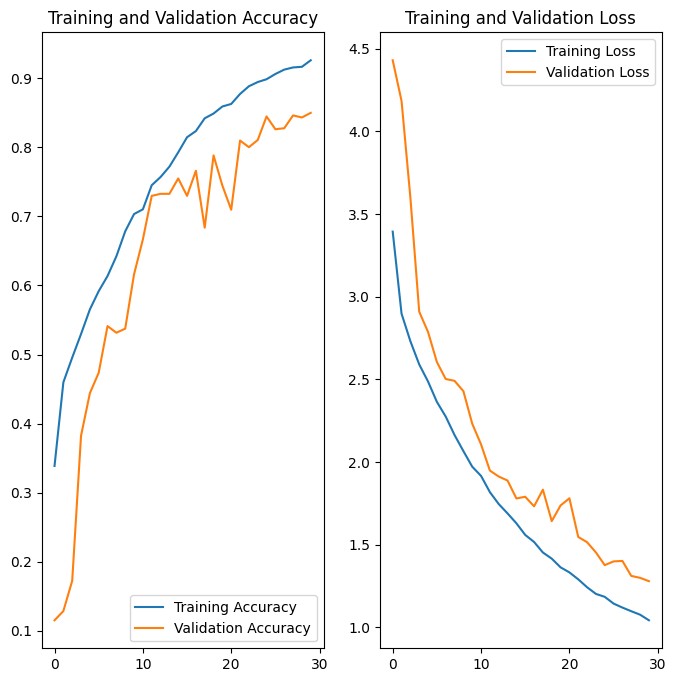

In [232]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


- **Inference about Model 3**


1.   Training loss start from 3.3936 and decreases to 1.0424 by last epoch which suggests that loss has been steadily decreasing as the model is progressing and fitting better with epochs.
2.   Training Accuracy starts from approx. 33% and goes till 92% approx which suggests that model is learning and becoming more accurate as training happens.
3. Validation loss starts from 4.4301 and goes till 1.2790 by end of training.
4. Validation Accuracy start from 11.51% and goes till 85% as training progresses.
5. The significant increase in model`s accuracy and decrease in loss suggests that model has been learning effectively and is not overfitting.
6. **Class rebalance** has definately helped the model to combat overfitting and making it more accurate.
7. Along with class rebalance, difference techniques for learning rate example: Polynomial Decay, Exponential Decay, ReduceLROnPlateau , Callbacks etc, have been tried with enhancing the model architecture, along with regualrization techniques.

8. Among those, regularization, enhancing model architecture and early stopping has significantly helped.




### Above Model can be finalized for validation or can be used in real world scenarios.

To further decrease the complexity and make training better, below has been tried.

**Final Model**

In [ ]:
# Enhancing the model further
## your code goes here
from keras import regularizers
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


def create_augmented_cnn_model(input_shape=(img_height, img_width, 3), num_classes=9):
    """
    Creates a CNN model for image classification with 9 classes.

    Args:
    - input_shape: Tuple representing the shape of input images (height, width, channels).
    - num_classes: Number of classes to classify.

    Returns:
    - A compiled CNN model.
    """
    model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]

        # Convolutional  1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Convolutional  2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Convolutional  3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Flatten and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512,  kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.01)),
        layers.Dropout(0.5),  # dropout for fully connected layers
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_augmented_cnn_model()
optimizer = Adam( learning_rate=0.0001)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 52s 293ms/step - loss: 11.1339 - accuracy: 0.3119 - val_loss: 10.3985 - val_accuracy: 0.3192
Epoch 2/30
169/169 [==============================] - 49s 291ms/step - loss: 8.8505 - accuracy: 0.4577 - val_loss: 8.5161 - val_accuracy: 0.5063
Epoch 3/30
169/169 [==============================] - 50s 294ms/step - loss: 7.1412 - accuracy: 0.5074 - val_loss: 6.7608 - val_accuracy: 0.5316
Epoch 4/30
169/169 [==============================] - 50s 295ms/step - loss: 5.7691 - accuracy: 0.5304 - val_loss: 5.4227 - val_accuracy: 0.5501
Epoch 5/30
169/169 [==============================] - 50s 294ms/step - loss: 4.6670 - accuracy: 0.5734 - val_loss: 4.4064 - val_accuracy: 0.5612
Epoch 6/30
169/169 [==============================] - 49s 292ms/step - loss: 3.8381 - accuracy: 0.5827 - val_loss: 3.6587 - val_accuracy: 0.5902
Epoch 7/30
169/169 [==============================] - 50s 294ms/step - loss: 3.1891 - accuracy: 0.6131 - val_loss: 3.0561 - val_

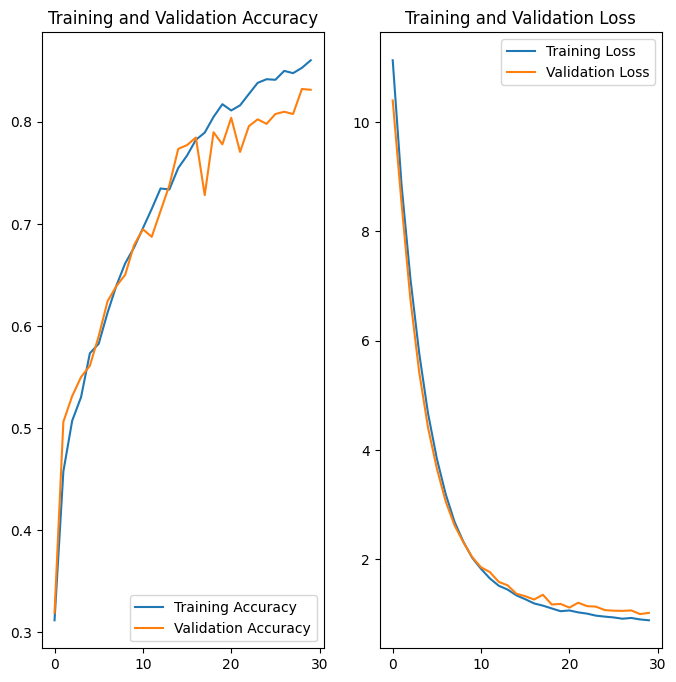

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**

From above, we can notice that a slight change in model architecture and keeping all the parameters , the model training has significantly improved.

Model has swiftly learned on training data and is good enough to validate on real or test data.

Model`s trainig loss and validation has swiftly decreasing and accuracies have been increasing steadily with 86% for training and 83% for validation.

With substantial decrease in loss and increase in accuracy makes this model as the final one to be used in real world or on test data.

# **Prediction**

1/1 [==============================] - 0s 456ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


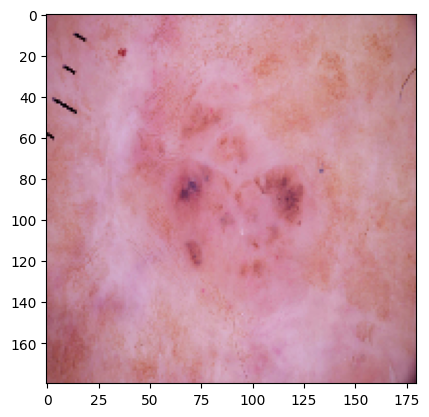

In [165]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )